# Statistical Processing for Halo Distribution
## Zhuowen Zhang, first created March 22, 2018


In [1]:
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from code.plot_utils import plot_pretty
plot_pretty()
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from code.halo_shape_calc import quad_moment
from code.lightcone_query_ra_dec import query_file, read_radial_bin
from code.setup.setup import data_home_dir
from code.setup.setup import code_home_dir
import pyfits
datadir = data_home_dir()
codedir = code_home_dir()


import astropy.io.fits as pyfits
import ConfigParser
import healpy as hp
import treecorr
import os

#kmeans_radec already installed in environment. No need to import 
#import code.kmeans_radec
#from code.kmeans_radec import KMeans, kmeans_sample 

In [54]:
#Import halo files
halos_shape = np.load(datadir+'halos_shape.npy')
#halos_shape = np.zeros(halos_num, dtype={'names':('halos_ID', 'richness', 'Mvir', 'Rvir', 'redshift', 'axes_len', \
#       'axes_dir', 'halos_dir', 'converge'),'formats':('i', 'f', 'f','f','f','(3,)f','(3,3)f','(3,)f','i')})

#Apply convergence cut
#print 'Positions not converge:', np.where(halos_shape['converge'] != 1)
conv_cut = np.where(halos_shape['converge']==True)
halos_shape = halos_shape[conv_cut]
halos_num = len(halos_shape)

#quantities to extract
halos_RA = halos_shape['halos_RA']; halos_DEC = halos_shape['halos_DEC']
halos_coord = np.array([halos_RA, halos_DEC]).T
axes_len = halos_shape['axes_len']
axes_dir = halos_shape['axes_dir']
q = axes_len[:,2]/axes_len[:,0]
s = axes_len[:,1]/axes_len[:,0]
richness = halos_shape['richness']
lmda_max = np.max(richness)

#Find angle
#Orientation PDF
halos_dir = halos_shape['halos_dir']
axes_dir = halos_shape['axes_dir']
major_dir = axes_dir[:,2,:]

#absolute value of cosine of axis between major axis and LOS
cos_i = np.zeros(halos_num) #cos(i) in lingo of Osato 2017
for i in range(halos_num):
    halos_dir_mag = np.linalg.norm(halos_dir[i])
    major_mag = np.linalg.norm(major_dir[i]);
    cos_i[i] = np.abs(np.dot(major_dir[i],halos_dir[i])/(halos_dir_mag * major_mag))
#convert cosine to angle in degrees
angle_los_halo = np.arccos(cos_i)*180/np.pi

In [49]:
from code.kmeans_radec import kmeans, kmeans_sample

#First instantiate an instance of the class. Import the RA, DEC of the files and check for center. 
#To do: Halo file to import
#Use Yuanyuan's code to compute mean and error on angle and ellipticities. 

ncen = 5
cen_guess=np.zeros( (ncen, 2) )
ra_guesses = cen_guess[:,0]
dec_guesses = cen_guess[:,1]
km=kmeans(halos_coord, cen_guess)
#km.run(halos_coord, maxiter=100)


# results are saved in attributes
print "Convergence is ", km.converged
#print(km.centers, km.labels, km.distances)
print("copy of centers:",km.get_centers())

X (1950, 2)  centers (5, 2)  tol=1e-05  maxiter=100
26 iterations  cluster sizes: [541 747 662]
Convergence is  True
('copy of centers:', array([[126.58016968,  56.16757011],
       [ 86.44126129,  18.70339335],
       [ 42.14180756,  42.97402408],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ]]))


In [121]:
#Jackknife Resampling
#Jackknife reference: https://www.utdallas.edu/~herve/abdi-Jackknife2010-pretty.pdf
#Extract quantities from km object
ncen =10
km = kmeans_sample(halos_coord, ncen, verbose=0)
km_centers = km.get_centers()
km_labels= km.find_nearest(halos_coord)
km_ncen = km.get_ncen()

#Check properties
#print("found centers:", len(km.centers))
#print("converged?", km.converged)
#print("labels size:", km.labels.size)
#print("cluster sizes:", np.bincount(km.labels))
#print("shape of distances:", km.distances.shape)

#set richness bins
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
lmda_bins_ind = []
for i, lmda_bin in enumerate(lmda_bins):
    #print i, lmda_bin
    lmda_bin_min = lmda_bin[0]; lmda_bin_max = lmda_bin[1]
    lmda_pos = np.where((richness >= lmda_bin_min) & (richness < lmda_bin_max))
    lmda_bins_ind.append(lmda_pos)
num_bins = len(lmda_bins_ind)
    
#Build array of test statistics
T_stat =[q, s, angle_los_halo]
num_stat = len(T_stat)
T_arr =np.zeros((num_stat,num_bins,3)) #3 for mean, number of samples, and SE. Model as Student-t 

#Array for test_statistics
for i in range(num_stat):  
    for j in range(num_bins):
        T_jk_list = []
        lmda_bin_min = lmda_bins[j][0]; lmda_bin_max = lmda_bins[j][1]
        for k in range(km_ncen):
        #    print 'Working on the No. %i Jacknife sample out of %i, richness %f to %f' \
        #            %(i, km.get_ncen(), lmda_min, lmda_max)
            jackknife_cut = np.where((richness >= lmda_bin_min) & (richness <= lmda_bin_max) & (km_labels != k))
            T_k_cut = T_stat[i][jackknife_cut]
            T_jk_list.append(T_k_cut)
        T_jk_list = np.asarray(T_jk_list)

        #jackknife estimator of mean
        T_rdu_arr = np.array([np.mean(T_jk_list[x]) for x in range(len(T_jk_list))]) #array of test statistic for ncen reduced jackknife sample
        T_num_samp = len(T_rdu_arr) #Number of samples 
        T_jk_mean = np.mean(T_rdu_arr)
        T_jk_var = np.var(T_rdu_arr, ddof=1)
        T_jk_std = np.std(T_rdu_arr, ddof=1) #ddof = 1 so that divide by (N-1), sample standard deviation
        T_jk_SE = (km_ncen-1.)/np.sqrt(km_ncen)*T_jk_std #std of the mean
        print 'Mean and standard error of statistic is', T_jk_mean, T_jk_SE
        #print 'Mean and standard error from biased sample is ', np.mean(q[lmda_bins_ind[2]]), \
        #                                           np.std(q[lmda_bins_ind[2]])/np.sqrt(len(q[lmda_bins_ind[2]]))
            
        #Save into T_arr
        T_arr[i,j,0] = T_jk_mean; T_arr[i,j,1] = T_num_samp; T_arr[i,j,2] = T_jk_SE

Mean and standard error of statistic is 0.54166085 0.002824698860086466
Mean and standard error of statistic is 0.5383905 0.0033114436938530634
Mean and standard error of statistic is 0.5194659 0.003620615529311722
Mean and standard error of statistic is 0.68912107 0.003745285391532665
Mean and standard error of statistic is 0.6827589 0.0038391090066363974
Mean and standard error of statistic is 0.6771741 0.004872881716897712
Mean and standard error of statistic is 50.90227230831226 0.7503062364047726
Mean and standard error of statistic is 49.71792598853078 0.6862504142601517
Mean and standard error of statistic is 43.543743292561985 2.7147231603440622


## Null hypothesis testing for different distributions 

In [122]:
from scipy.stats import t
#Compare with Student-t distribution
print t.std(df=(km_ncen-1), scale = T_SE)
print t.interval(0.95,df=(km_ncen-1), scale=T_SE)

#Conduct a Student-t test for comparing means with unequal variances. 
#Reference: https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading19.pdf
#test q in bin 0 and bin 2

#T_arr[num_stats,num_bins,3]. 3 for mean, number of samples, and SE.
SE_x = T_arr[2,0,2]; SE_y = T_arr[2,2,2]; n_samp = T_arr[2,0,1]
x_mean = T_arr[2,0,0]; y_mean = T_arr[2,2,0]
SE_pool = np.sqrt(SE_x**2. + SE_y**2.)
dof_pool = SE_pool**2./(SE_x**2./(n_samp*(n_samp-1.)) + SE_y**2./(n_samp*(n_samp-1.)))
test_stat = (x_mean - y_mean)/SE_pool

p_val = 0.05
null_range = t.interval(1-p_val, df=dof_pool,loc=0,scale=1)
print x_mean, y_mean, SE_pool
print test_stat, null_range

#Do this with q first to make easy your life. 




0.002917200587062149
(-0.005819917544661012, 0.005819917544661012)
50.90227230831226 43.543743292561985 2.816501604064224
2.6126486152650825 (-1.9866745405784678, 1.9866745405784678)


[Text(0,0,'$\\lambda \\in [20.0, 30.0)$'),
 Text(0,0,'$\\lambda \\in [30.0, 50.0)$'),
 Text(0,0,'$\\lambda \\in [50.0, 135.4)$')]

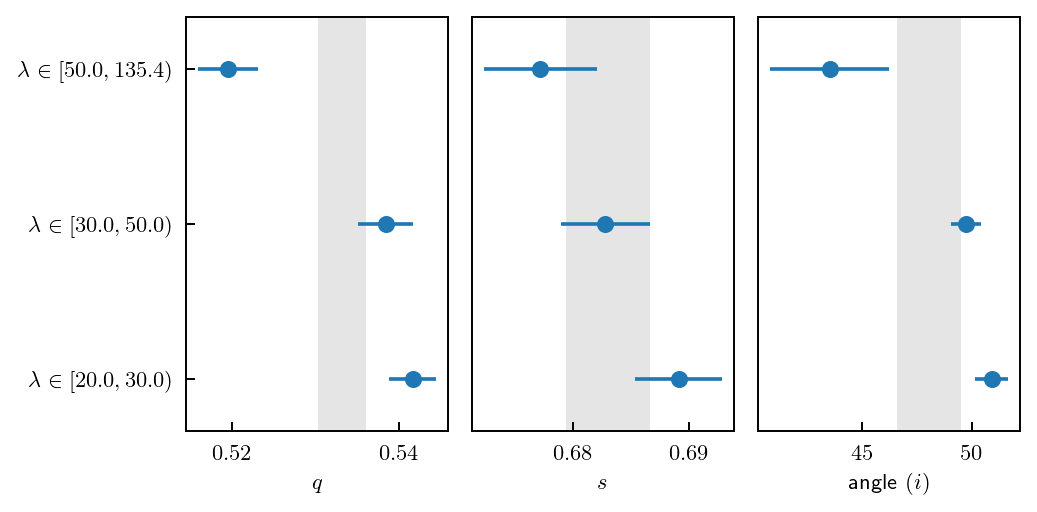

In [143]:
#Plotting error bars
fig, axs = plt.subplots(1 ,num_stat, tight_layout=True, figsize=(6,3))

#ax.fill_between(x, y1, y2, where=y2 >= y1, facecolor='green', interpolate=True)
#ax.fill_between(x, y1, y2, where=y2 <= y1, facecolor='red', interpolate=True)
yticks = [0.1, 0.4, 0.7]
yticklabels = []
xlabels = [r'$q$', r'$s$', r'angle $(i)$']
for i, lmda_bin_i in enumerate(lmda_bins):
    yticklabels_i = r'$\lambda \in [{:.1f}, {:.1f})$'.format(lmda_bin_i[0], lmda_bin_i[1])
    yticklabels.append(yticklabels_i)
#print yticklabels

for i in range(num_stat):
    #Consider as a next step combining ONLY datat that are consistent. 
    SE_combine = np.sqrt(np.sum([T_arr[i,x,2]**2. for x in range(num_bins)]))
    stat_tot_num = np.sum([T_arr[i,x,1] for x in range(num_bins)])
    mean_combine = np.sum([T_arr[i,x,0]*T_arr[i,x,1] for x in range(num_bins)])/stat_tot_num
    axs[i].bar(mean_combine, height=1, width=SE_combine, alpha=0.2, color='gray')
    axs[i].errorbar(T_arr[i,:,0],yticks, xerr=T_arr[i,:,2], fmt='o')
    axs[i].set_xlabel(xlabels[i])
    axs[i].set_yticks([])
    axs[i].set_ylim((0,0.8))
axs[0].set_yticks(yticks)
axs[0].set_yticklabels(yticklabels)